In [1]:
import pandas as pd
import os
path = os.getcwd()

df = pd.read_excel(path + "/Native_Load_2024.xlsx")
df2 = pd.read_excel(path + "/Native_Load_2023.xlsx")
df3 = pd.read_excel(path + "/Native_Load_2022.xlsx")

# merge the dataframes 
merged_df = pd.concat([df3, df2, df], ignore_index=True)

# save the merged dataframe to a new excel file
merged_df.to_excel(path + "/Native_Load_Merged.xlsx", index=False)

<Axes: >

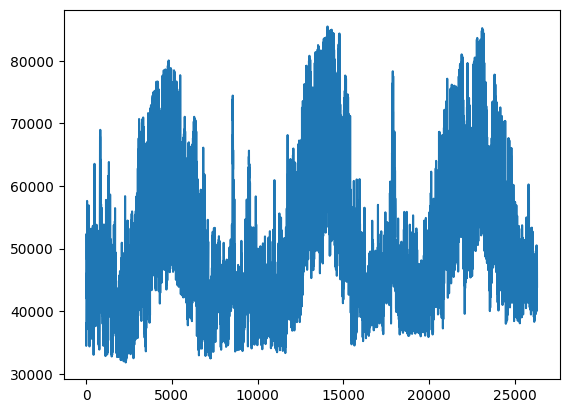

In [13]:
import pandas as pd
from prophet import Prophet
import os
import matplotlib.pyplot as plt
%matplotlib inline

path = os.getcwd()
df = pd.read_excel(path +'/Native_Load_Merged.xlsx')
df.rename(columns={"Hour Ending": "date"}, inplace=True)

# Replace "24:00" with "00:00" of the next day
df["date"] = df["date"].str.replace(" 24:00", " 00:00")
df["date"] = df["date"].str.replace(" DST", "")
df["date"] = pd.to_datetime(df["date"], format="%m/%d/%Y %H:%M")

df["ERCOT"].plot()



18:54:47 - cmdstanpy - INFO - Chain [1] start processing
18:54:52 - cmdstanpy - INFO - Chain [1] done processing


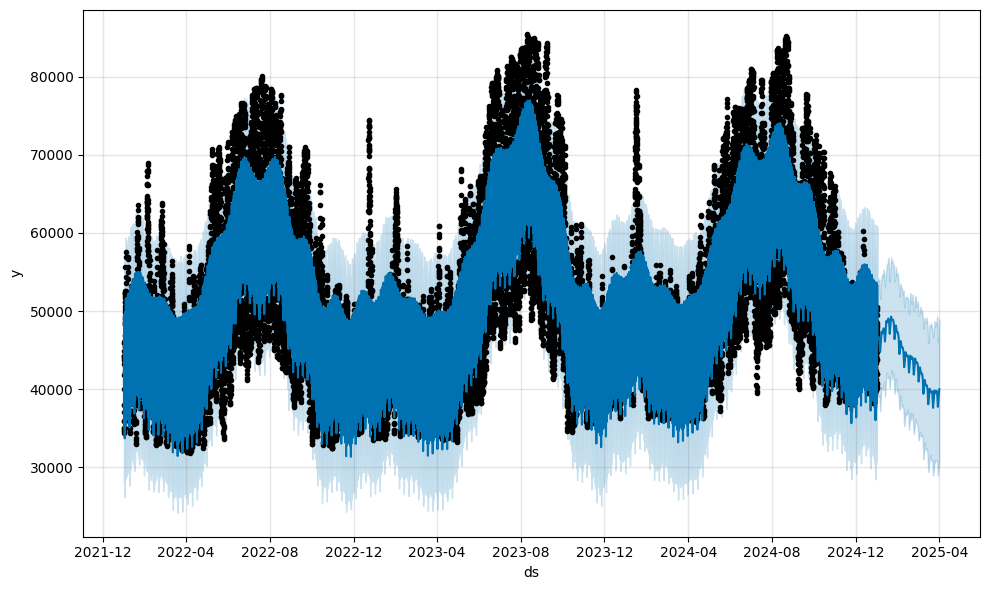

In [14]:
df1 = df[["date", "ERCOT"]].copy()
df1.columns = ["ds", "y"]
# Drop any rows with NaN values
df1 = df1.dropna()
m = Prophet()
m.fit(df1)

future = m.make_future_dataframe(periods=90, freq='D')
fcst = m.predict(future)
fig = m.plot(fcst)

In [15]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()



ds          yhat    yhat_lower    yhat_upper
26385 2025-03-27 23:00:00  39792.271552  29960.845642  48361.001810
26386 2025-03-28 23:00:00  39496.583622  30813.071890  48720.078814
26387 2025-03-29 23:00:00  37737.043848  28191.648044  45802.666279
26388 2025-03-30 23:00:00  38757.085999  30048.523840  47944.838204
26389 2025-03-31 23:00:00  39989.161378  30620.053358  49618.327343

In [7]:
import plotly.graph_objects as go

def timeseries(df, x, yhat, lower, upper, actual, title_name, save = False):

    fig = go.Figure([
        go.Scatter(
            name='Measurement',
            x=df[x],
            y=df['yhat'],
            mode='lines',
            line=dict(color='rgb(31, 119, 180)'),
            showlegend=False
        ),
        go.Scatter(
            name='Upper Bound',
            x=df[x],
            y=df[upper],
            mode='lines',
            marker=dict(color="#444"),
            line=dict(width=0),
            showlegend=False
        ),
        go.Scatter(
            name='Lower Bound',
            x=df[x],
            y=df[lower],
            marker=dict(color="#444"),
            line=dict(width=0),
            mode='lines',
            fillcolor='rgba(68, 68, 68, 0.3)',
            fill='tonexty',
            showlegend=False
        )
    ])
    fig.update_layout(
        yaxis_title='Production Rate',
        title=f'{title_name}',
        hovermode="x"
    )
    fig.add_trace(go.Scatter(x=actual['ds'], y=actual["y"],
                    mode='lines+markers',
                    name='Actual values',
                    showlegend=False)) 
    
    fig.show()
    
    if save: 
        fig.write_html(f"{title_name}.html")


timeseries(forecast,'ds', 'yhat', 'yhat_lower', \
    'yhat_upper', actual = df1, title_name='Ercot', save = True)



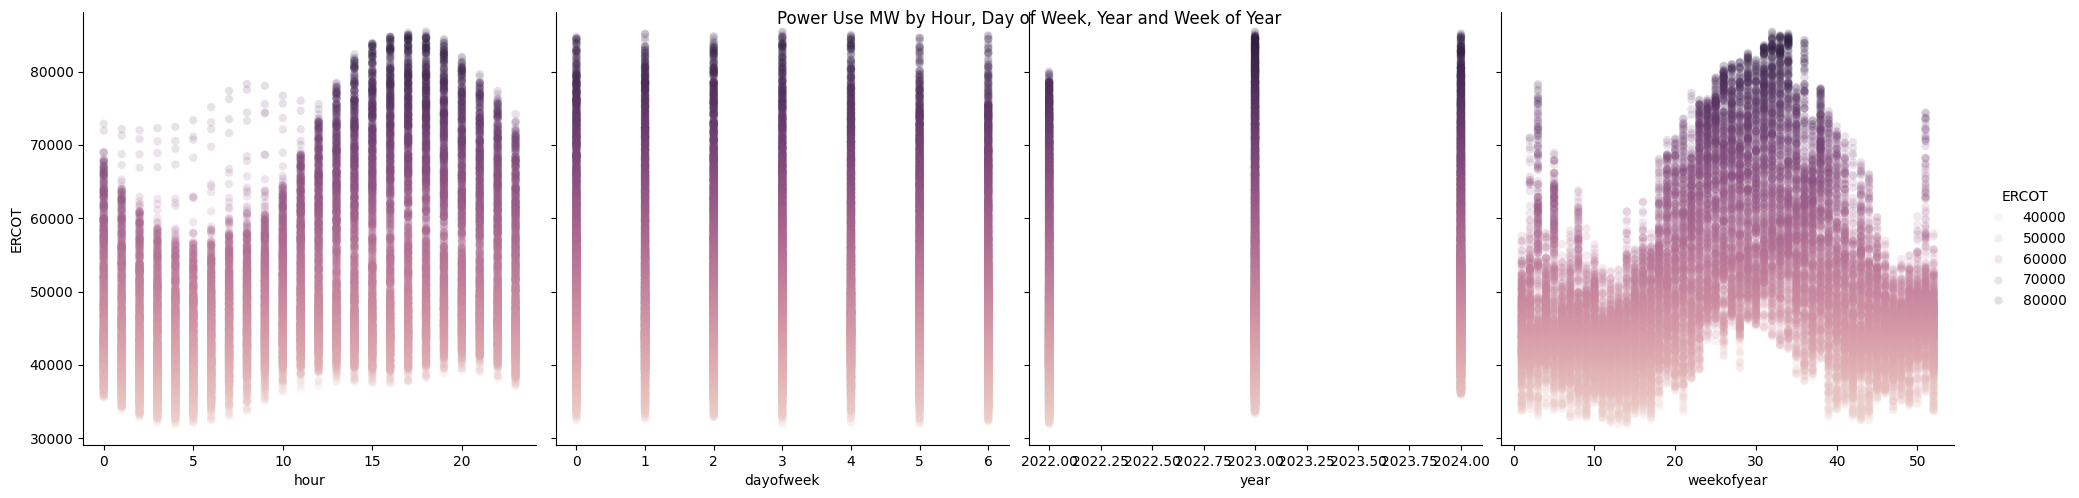

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

def create_features(df, label=None):
    df = df.copy()
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df, label='ERCOT')

features_and_target = pd.concat([X, y], axis=1)

features_and_target.head()

sns.pairplot(features_and_target.dropna(),
             hue='ERCOT',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars='ERCOT',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )


plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()



ds             y
0 2022-01-01 01:00:00  38006.938896
1 2022-01-01 02:00:00  37036.522365
2 2022-01-01 03:00:00  35881.607998
3 2022-01-01 04:00:00  35044.055105
4 2022-01-01 05:00:00  34585.571140

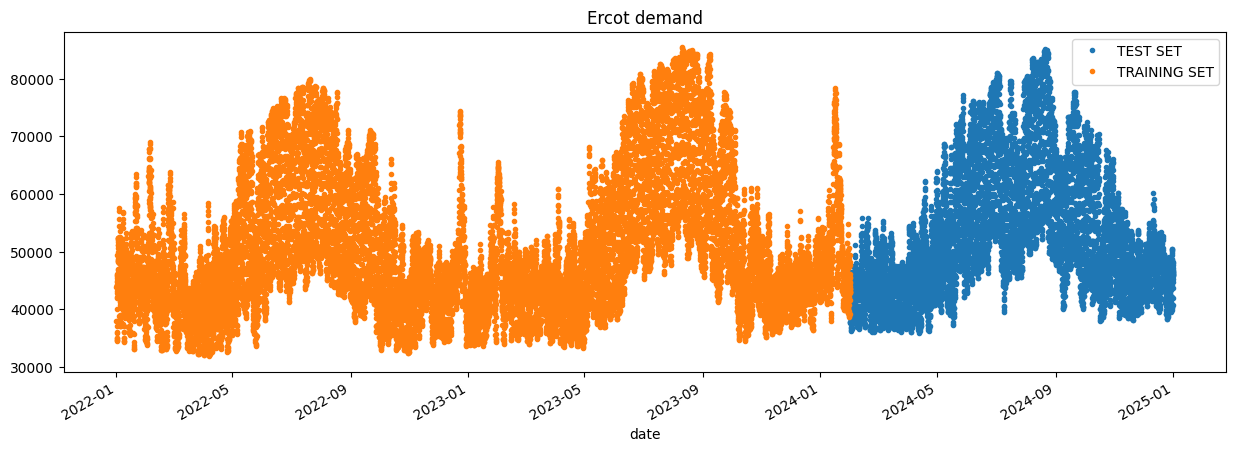

In [9]:
split_date = '01-Feb-2024'
ercot = df[['date',"ERCOT"]]
ercot.set_index("date", inplace=True)
ercot_train = ercot.loc[ercot.index <= split_date].copy()
ercot_test = ercot.loc[ercot.index > split_date].copy()

ercot_test.rename(columns={'ERCOT': 'TEST SET'}) \
    .join(ercot_train.rename(columns={'ERCOT': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='Ercot demand', style='.')


ercot_train.reset_index() \
    .rename(columns={'date':'ds','ERCOT':'y'}).head()

16:15:27 - cmdstanpy - INFO - Chain [1] start processing
16:15:29 - cmdstanpy - INFO - Chain [1] done processing


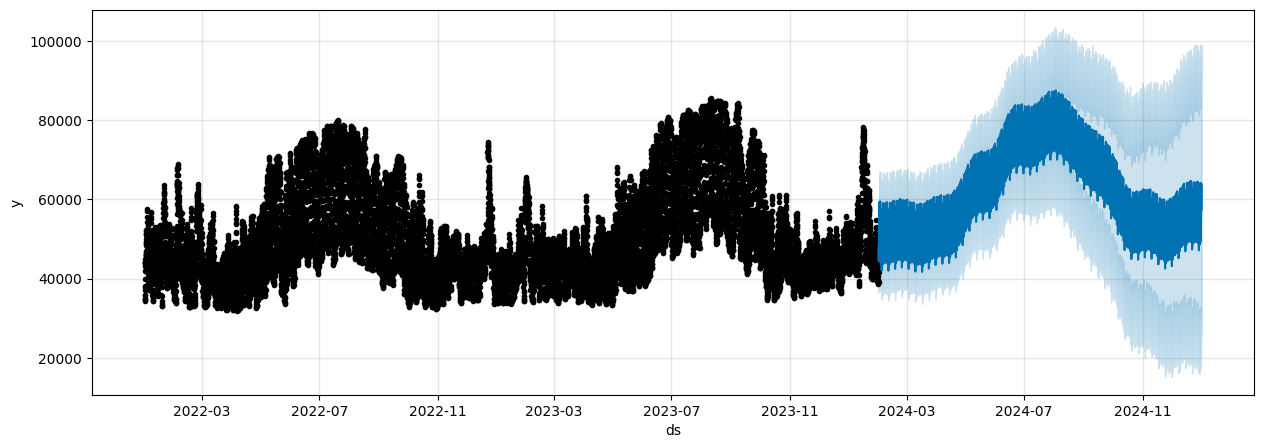

In [10]:
model = Prophet()
model.fit(ercot_train.reset_index() \
              .rename(columns={'date':'ds',
                               'ERCOT':'y'}))

ercot_test_fcst = model.predict(df=ercot_test.reset_index() \
                                   .rename(columns={'date':'ds'}))

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(ercot_test_fcst, ax=ax)
plt.show()

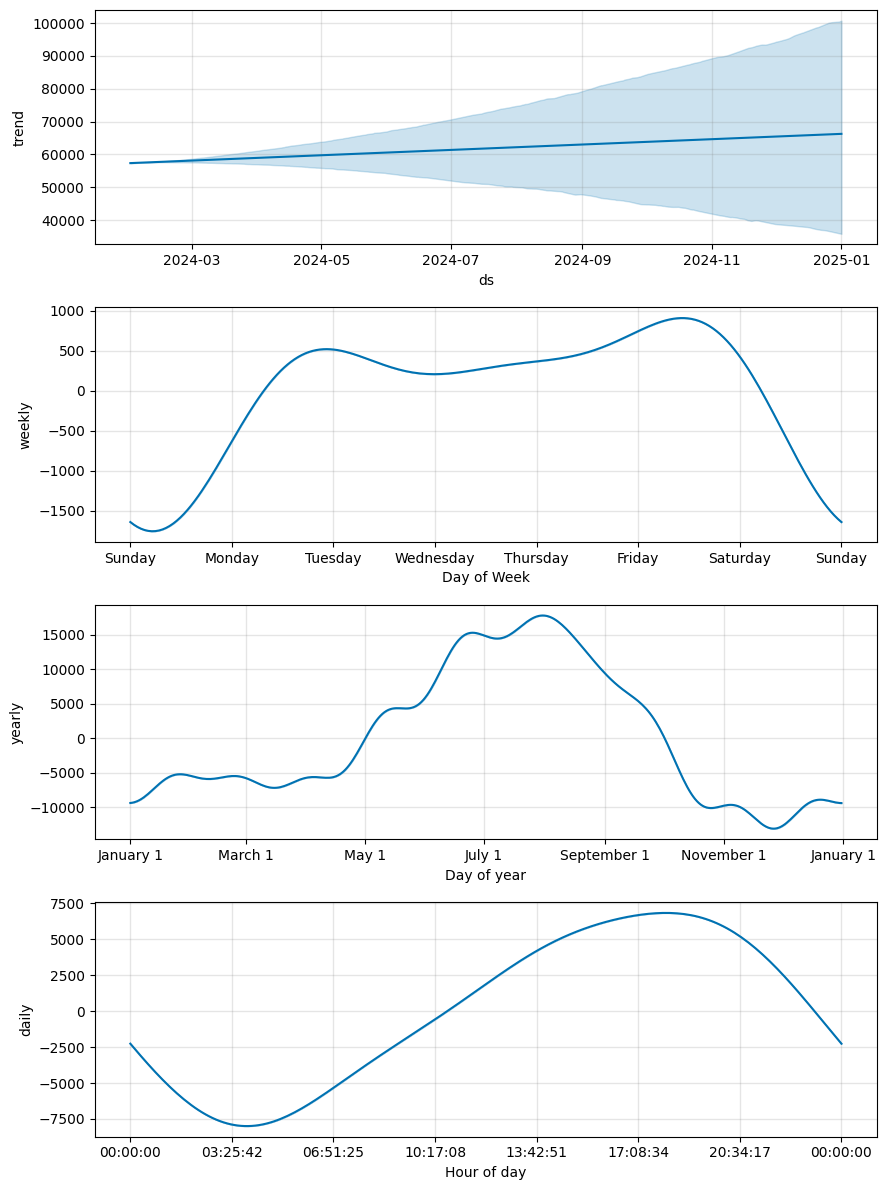

In [11]:
fig = model.plot_components(ercot_test_fcst)

MSE: 132198441.1346772
MAE: 10032.451505446437
RMSE: 11497.758091674968


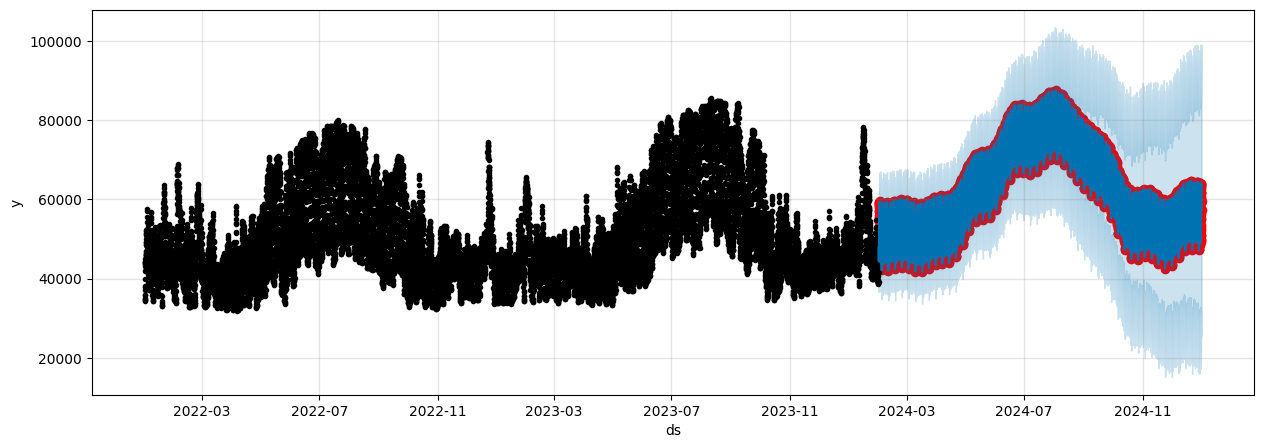

In [12]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(ercot_test_fcst['ds'], ercot_test_fcst['yhat'], color='r')
fig = model.plot(ercot_test_fcst, ax=ax)


# Calculate the error metrics
y_true = ercot_test.reset_index() \
    .rename(columns={'date':'ds','ERCOT':'y'})['y']
y_pred = ercot_test_fcst['yhat']
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')